# Biodiversity Intactness Index
#### Author: Brooke Grazda
#### [Link to Repository](https://github.com/bgrazda/eds220-final.git)

**Purpose:** This notebook aims to examine the differences in biodiversity intactness of Phoenix County from 2017 to 2020. Using Microsoft Planetary Computer and Census data, this analysis hopes to look at where these areas of biodiversity loss occur to inform better protections fo these areas.

**Highlights:** Some highlights of this notebook include practicing with STAC catalogs, searches, collections, and items. Using the Microsoft Planetary Computer, this notebook accesses biodiversity satellite imagery data to overlay with a shapefile geodataframe. This notebook utilizes `contextily`, which provides a basemap for providing geographic context to where biodiversity is located within the Phoenix region. Another important aspect of this coding exercises is doing raster math to determine which areas lost more than 75% of their biodiversity in 2017 and 2020.

**About the Data:** [Microsoft's Planetary Computer (MPC)](https://planetarycomputer.microsoft.com) STAC API follows an open standard for geospatial data that aims to increase the interoperability of geospatial data, particularly satellite imagery. The Phoenix shapefiles  data can be directly accessed by using this [link](https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2020&layergroup=County+Subdivisions) and selecting Arizona when prompted for County Subdivision.

**References:**

Galaz García, Carmen. Final Project – EDS 220 - Working with Environmental Datasets. (n.d.). https://meds-eds-220.github.io/MEDS-eds-220-course/assignments/final-project.html

Microsoft Planetary Computer. (n.d.). https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2

2020 Tiger/line® Shapefiles: County+Subdivisions. United States Census Bureau. (n.d.). https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2020&layergroup=County%2BSubdivisions 


In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import rioxarray as rioxr
from pystac_client import Client  # To access STAC catalogs
import planetary_computer  # To sign items from the MPC STAC catalog 
from IPython.display import Image  # To nicely display images
from geogif import gif
from shapely.geometry import box
import xarray as xr
import os
from pystac import Catalog, get_stac_version
import contextily as cx
import matplotlib.patches as mpatches

## Import Data

In [2]:
# Import Biodiversity Intactness collection
catalog = Client.open('https://planetarycomputer.microsoft.com/api/stac/v1',
                     modifier=planetary_computer.sign_inplace)
collection = catalog.get_collection("io-biodiversity")
collection.title

'Biodiversity Intactness'

In [3]:
# Read in Arizona shapefile
arizona_bound = gpd.read_file(os.path.join('data', 
                                          'tl_2020_04_cousub.shp'))

## Data Exploration

<Axes: >

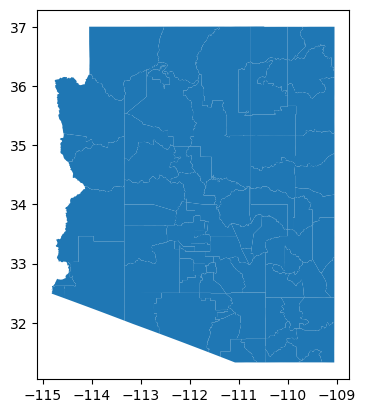

In [4]:
# Visualize geodf
arizona_bound.plot()

In [5]:
# Examine first 5 observations
arizona_bound.head()

,STATEFP,COUNTYFP,COUSUBFP,COUSUBNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CNECTAFP,NECTAFP,NCTADVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,04,015,91964,02582914,0401591964,Lake Havasu City,Lake Havasu City CCD,22,Z5,G4040,None,None,None,S,7493863105,50863803,+34.7686221,-113.8749805,"POLYGON ((-114.48778 34.71722, -114.48622 34.7..."
1,04,007,91277,02582913,0400791277,Fort Apache,Fort Apache CCD,22,Z5,G4040,None,None,None,S,2134058292,4388167,+33.8847663,-110.3394452,"POLYGON ((-110.78327 34.16750, -110.78276 34.1..."
2,04,003,90306,01934923,0400390306,Bisbee,Bisbee CCD,22,Z5,G4040,None,None,None,S,1610943633,3494169,+31.4580397,-110.0783372,"POLYGON ((-110.46089 31.47376, -110.46089 31.4..."
3,04,003,90408,01934925,0400390408,Bowie,Bowie CCD,22,Z5,G4040,None,None,None,S,3556140749,1110460,+32.1699052,-109.3999964,"POLYGON ((-109.76866 32.30583, -109.76787 32.3..."
4,04,003,93825,01934992,0400393825,Willcox,Willcox CCD,22,Z5,G4040,None,None,None,S,1898081614,4959613,+32.1980984,-109.8877527,"POLYGON ((-110.15218 32.17203, -110.15213 32.1..."


In [6]:
# Get more informaiton about CRS
print('ellipsoid: ', arizona_bound.crs.ellipsoid)
print('datum: ', arizona_bound.crs.datum)
print('is geographic?', arizona_bound.crs.is_geographic)
print('is projected?', arizona_bound.crs.is_projected)

ellipsoid:  GRS 1980
datum:  North American Datum 1983
is geographic? True
is projected? False


In [7]:
# Look at contents of collection
collection

<CollectionClient id=io-biodiversity>

In [8]:
# Look at Geodf datatypes
arizona_bound.dtypes

STATEFP       object
COUNTYFP      object
COUSUBFP      object
COUSUBNS      object
GEOID         object
NAME          object
NAMELSAD      object
LSAD          object
CLASSFP       object
MTFCC         object
CNECTAFP      object
NECTAFP       object
NCTADVFP      object
FUNCSTAT      object
ALAND          int64
AWATER         int64
INTPTLAT      object
INTPTLON      object
geometry    geometry
dtype: object

In [9]:
# Look at CRS
arizona_bound.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

### Preliminary Observations

From the initial exploration of both datasets, I learned that the arizona county subdivisions geodataframe has a geographic CRS of GRS 1980. The datum is the North American Datum 9183. I also saw that the majority of the data types are string objects, except for the columns `ALAND` and `AWATER`, which were integers, and the geometries. I viewed the first 5 observations in the arizona geodataframe to ensure that the clipping was correct using the bbox coordinates.

The Biodiversity Intactness Index collection describes its maps to depict biodivrresity intacness over the years 2017 to 2020 with high spatial resolution. The current bounding box for the STAC collection is [-180, -90, 180, 90] so I will have to adjust the bounding box to match that of Arizona county subdivisions.

In [10]:
# Phoenix coordinates
bbox = [-112.826843, 32.974108, -111.184387, 33.863574]

# Search for collection data in catalog STAC using bbox coordinates
search = catalog.search(
collections = collection,
bbox = bbox)

search

In [11]:
# Get items in the collection of biodiversity intactness for Phoenix
items = search.item_collection()
len(items)

4

In [12]:
# Look at each item in the list
items = list(search.items())
for item in items:
    print(item)

<Item id=bii_2020_34.74464974521749_-115.38597824385106_cog>
<Item id=bii_2019_34.74464974521749_-115.38597824385106_cog>
<Item id=bii_2018_34.74464974521749_-115.38597824385106_cog>
<Item id=bii_2017_34.74464974521749_-115.38597824385106_cog>


In [14]:
# Select any item to look at names for data access
item = items[0]

# Names of the asset keys
for key in item.assets.keys():
    print(key, '--', item.assets[key].title)

data -- Biodiversity Intactness
tilejson -- TileJSON with default rendering
rendered_preview -- Rendered preview


In [15]:
# Select item for both years
bii_2020_item = items[0]

bii_2017_item = items[3]

{'datetime': None, 'proj:epsg': 4326, 'proj:shape': [7992, 7992], 'end_datetime': '2020-12-31T23:59:59Z', 'proj:transform': [0.0008983152841195215, 0.0, -115.38597824385106, 0.0, -0.0008983152841195215, 34.74464974521749, 0.0, 0.0, 1.0], 'start_datetime': '2020-01-01T00:00:00Z'}
{'datetime': None, 'proj:epsg': 4326, 'proj:shape': [7992, 7992], 'end_datetime': '2017-12-31T23:59:59Z', 'proj:transform': [0.0008983152841195215, 0.0, -115.38597824385106, 0.0, -0.0008983152841195215, 34.74464974521749, 0.0, 0.0, 1.0], 'start_datetime': '2017-01-01T00:00:00Z'}


In [16]:
# Open the data 
bii_2017 = rioxr.open_rasterio(bii_2017_item.assets['data'].href)
bii_2020 = rioxr.open_rasterio(bii_2020_item.assets['data'].href)

## Phoenix within broader geographic context

<Axes: >

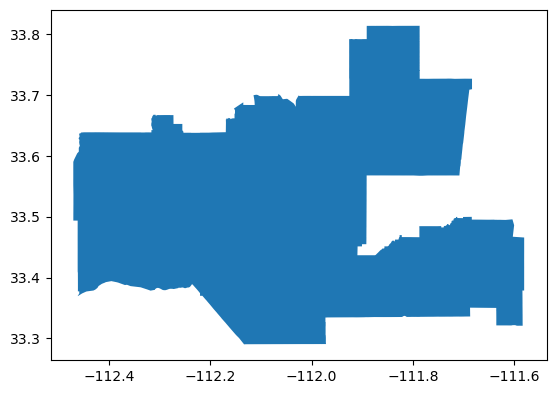

In [17]:
# Filter for Phoenix county
phoenix = arizona_bound[arizona_bound.NAME == 'Phoenix']

# Initial plot
phoenix.plot()

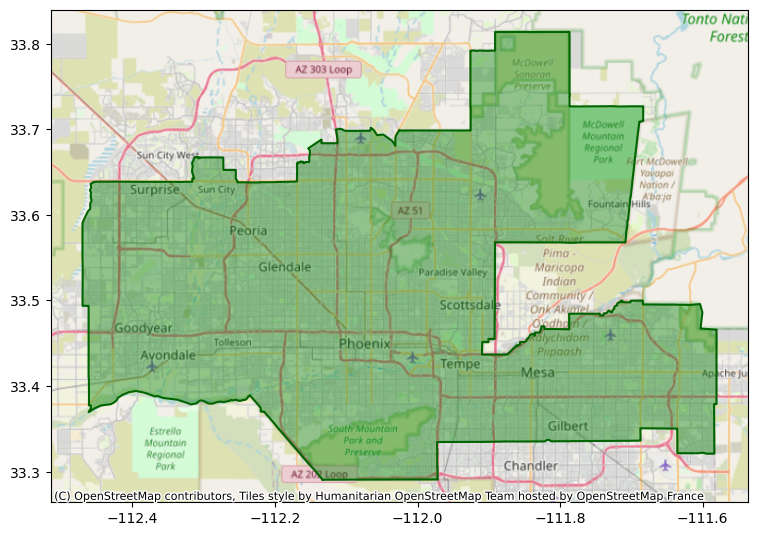

In [32]:
# Phoenix subdivision in broader geographic context
ax = phoenix.plot(figsize=(9,9), 
                  alpha = .4,
                 color = 'green')


phoenix.boundary.plot(ax = ax, 
                     color = 'darkgreen')
# Use contextily to show roads
cx.add_basemap(ax, crs = phoenix.crs)

## Wrangle rioxarray and geodf data for calculations and plotting

In [19]:
# Original dimensions and coordinates
print(bii_2017.dims, bii_2017.coords,'\n')

# Remove band dimension of length 1
bii_2017 = bii_2017.squeeze()
print(bii_2017.dims, bii_2017.coords,'\n')

# Remove coordinates associated to band
bii_2017 = bii_2017.drop_vars('band')
print(bii_2017.dims, bii_2017.coords)

('band', 'y', 'x') Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 64kB -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 64kB 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57
    spatial_ref  int64 8B 0 

('y', 'x') Coordinates:
    band         int64 8B 1
  * x            (x) float64 64kB -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 64kB 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57
    spatial_ref  int64 8B 0 

('y', 'x') Coordinates:
  * x            (x) float64 64kB -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 64kB 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57
    spatial_ref  int64 8B 0


In [20]:
# Transform phoenix CRS to match the raster CRS
phoenix = phoenix.to_crs('epsg:4326')

In [21]:
# Creat geodf bbox to clip the STAC
# Bounding box as geodataframe
box_df = gpd.GeoDataFrame(geometry=[box(*bbox)],
                 crs='epsg:4326') 

In [67]:
print(bii_2017.rio.crs)
print(box_df.crs)
print(bii_2017.rio.bounds)
print(box_df.total_bounds)

bii_2017 = bii_2017.rio.clip(box_df.geometry, box_df.crs)

EPSG:4326
epsg:4326
<bound method XRasterBase.bounds of <rioxarray.raster_array.RasterArray object at 0x7f9eba070110>>
[-112.826843   32.974108 -111.184387   33.863574]


In [66]:
# Explore values 
print(bii_2020.rio.crs)
print(box_df.crs)
print(bii_2020.rio.bounds)
print(box_df.total_bounds)

# Clip 2020 raster to the bbox
bii_2020 = bii_2020.rio.clip(box_df.geometry, box_df.crs)

EPSG:4326
epsg:4326
<bound method XRasterBase.bounds of <rioxarray.raster_array.RasterArray object at 0x7f9eb9e16b10>>
[-112.826843   32.974108 -111.184387   33.863574]


## Calculate percentage of area with BII greater than 0.75

In [25]:
# Open the raster data from our 2017 and 2020 items
phoenix_2017 = rioxr.open_rasterio(bii_2017_item.assets['data'].href)
phoenix_2020 = rioxr.open_rasterio(bii_2020_item.assets['data'].href)

In [59]:
# Assign empty cells to nan
phoenix_2017 = phoenix_2017.rio.write_nodata(np.nan)
phoenix_2017_clip = (phoenix_2017.rio.clip_box(*phoenix.total_bounds).rio.clip(phoenix.geometry))


phoenix_2020 = phoenix_2020.rio.write_nodata(np.nan)
phoenix_2020_clip = (phoenix_2020.rio.clip_box(*phoenix.total_bounds).rio.clip(phoenix.geometry))

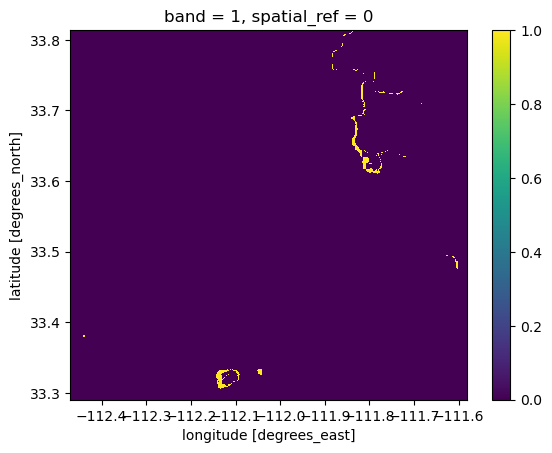

In [63]:
# Create new data frame where both the 2017 and 2018 xarrays are greater than 0.75
phoenix_diff = (phoenix_2017_clip >= 0.75) ^ (phoenix_2020_clip >= 0.75)

phoenix_diff.plot()

In [70]:
# Do the same operation with previous df, but coerce into an xarray
phoenix_diff_xarray = xr.where(phoenix_diff, 1,  np.nan)

## Data Visualization: BII of Phoenix

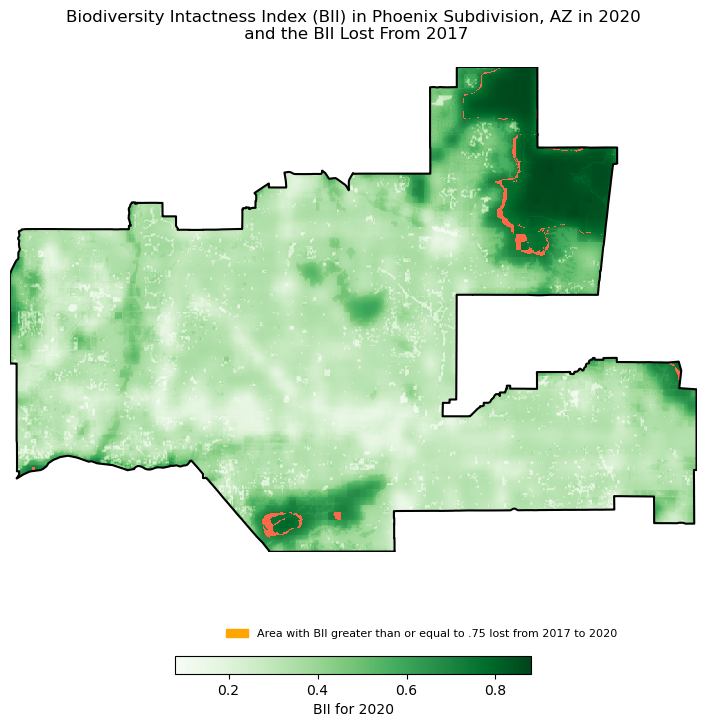

In [71]:
# Initialize subplots
fig, ax = plt.subplots(figsize=(9,9))
ax.axis('off')

# Plot the boundary of Phoenix
phoenix.boundary.plot(ax = ax,
                     color = 'black')

# Plot the raster on the same axis
phoenix_2020_clip.plot(ax=ax, cmap="Greens", 
                       cbar_kwargs={'location': 'bottom', 'label': 'BII for 2020', 'shrink': 0.51})

# Add a custom legend element manually
custom_patch = mpatches.Patch(color='orange', label='Area with BII greater than or equal to .75 lost from 2017 to 2020')

# Add custom legend
ax.legend(handles=[custom_patch], loc='lower center', fontsize=8, frameon=False, bbox_to_anchor=(0.6, -0.2))

# Plot the difference data
phoenix_diff_xarray.plot(ax=ax, cmap="Reds", add_colorbar=False)

# Set the title
ax.set_title("Biodiversity Intactness Index (BII) in Phoenix Subdivision, AZ in 2020\n and the BII Lost From 2017", 
             fontsize=12, loc='center', pad=20)

# Show plot
plt.show()

## Summary

Examining the results, it appears that the most intact biodiverse areas are in the top right and central bottom areas of Phoenix. Within the three years from 2017 to 2020, areas with over 75% lost biodiverse have also occurred in these same areas, where there is the most biodiversity. This can be used for increased protections on existing biodiversity, as this visualization shows that it is easily lost in even the most intact areas. Phoenix is a large metropolitan area in Arizona, as indicated by the visualization of the Phoenix subdivision with the basemap. Comparing the two images, the areas that are experiencing biodiversity loss are in the outskirts, wehre there are more natural areas. For example, the McDowell Mountain Regional Park is lcoated in the top right region of Phoenix. These analyses can be used to encourage local regulations on these natural areas.